In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
%matplotlib inline
from tqdm.auto import tqdm
import matplotlib.patheffects as pe

import matplotlib.pyplot as plt

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

figaspectratio = 1.25

In [2]:
def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

def fixed_axis_lightcurve(theta,a,b,c):
    dist=np.abs(np.sin(theta)*np.tan(theta)*a**2+c**2*np.cos(theta))
    beta=np.sqrt(c**2+a**2*np.tan(theta)**2)

    return(np.pi*b*dist/beta)

def fixedHfunction(time,p,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(fixed_axis_lightcurve(beta-betainit,115,111,19))
    return(curve)

In [3]:
a,b,c=115,111,19

belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv",comment='#')

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

cutoff=55.5
octbeltime=beltime[beltime<cutoff]
octbelmag=belmag[beltime<cutoff]
octbelsig=belsig[beltime<cutoff]

cutoff=78
novbeltime=beltime[beltime>cutoff]
novbelmag=belmag[beltime>cutoff]
novbelsig=belsig[beltime>cutoff]

In [8]:
fixedpopt,_=curve_fit(fixedHfunction,(octbeltime),octbelmag,p0=[7.36,1.7,33.25],
                    sigma=octbelsig,absolute_sigma=False,
                    bounds=([5,0,20],[10,2*np.pi,40]),maxfev=5000)

times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
print(fixedpopt)
curve=fixedHfunction(times,*fixedpopt)

print("chi^2:",chi2(fixedHfunction(octbeltime,*fixedpopt),octbelmag,octbelsig))

[ 7.38217299  0.90891661 33.49114145]
chi^2: 32113.465779506725


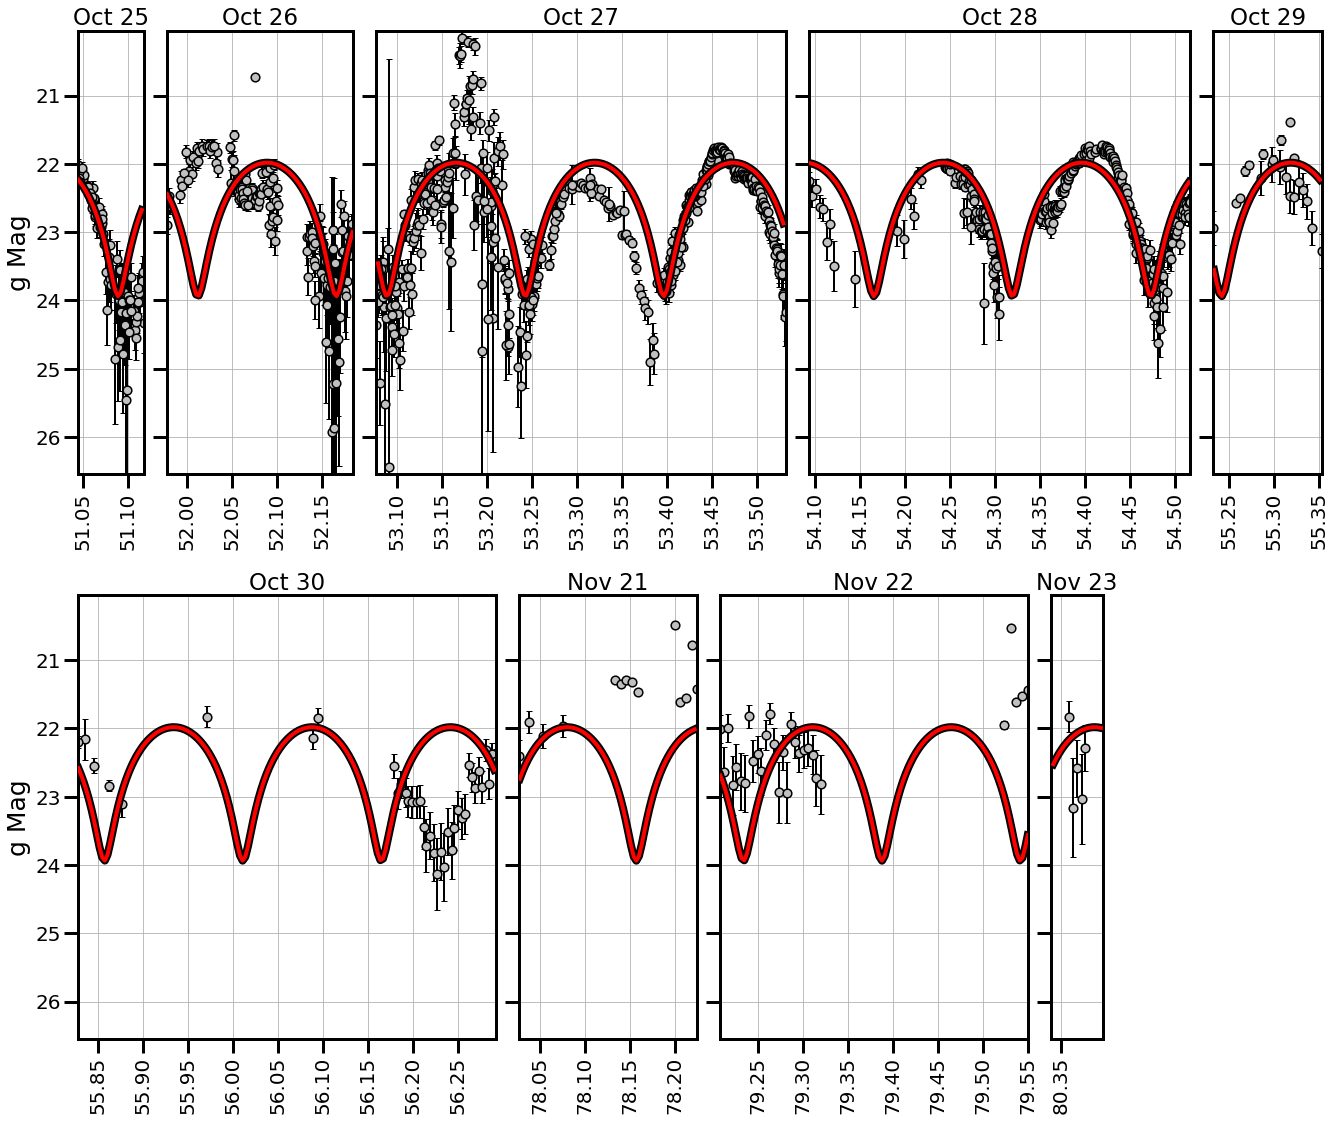

In [5]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))
    
axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
    ax.scatter(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2,rasterized=True)
    ax.plot(times[np.where((times<=xmax)&(times>=xmin))],
                 curve[np.where((times<=xmax)&(times>=xmin))],
                 color='r',zorder=3,lw=4,path_effects=[pe.Stroke(linewidth=8, foreground='k'), pe.Normal()])
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
plt.savefig('../Figures and Paper/fixed_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=150)